# Comment Toxicity Rater
- slimmed down from GDrive's ToxicityRater.ipynb (also contains cap letter count)
- profanity score + toxic probability (1 being 100% toxic, 0 being not toxic at all) + exclamation mark count (if more than 0.5 profanity score)


Resources from: 

1) https://pypi.org/project/alt-profanity-check/ 

2) https://github.com/importdata/Twitter-Sentiment-Analysis/blob/master/Twitter_Sentiment_Analysis_Support_Vector_Classifier.ipynb


In [ ]:
import sklearn
import numpy as np
import pandas as pd

In [ ]:
!pip install alt-profanity-check
!pip install joblib
!pip install scikit-learn
#install tweet-preprocessor to clean tweets
!pip install tweet-preprocessor


     |████████████████████████████████| 1.9 MB 10.7 MB/s 
  Created wheel for alt-profanity-check: filename=alt_profanity_check-1.0.1-py3-none-any.whl size=1865445 sha256=30895504d300556ea48846511ac3cd79a8e454ff5f3ef42c7b55b41769874a87
  Stored in directory: /root/.cache/pip/wheels/fa/02/1e/89a3a8fcf8a9507990a6c39951fcb47ee9838cce09e6fdcaed
Successfully built alt-profanity-check


In [ ]:
# remove special characters using the regular expression library
import re

#set up punctuations we want to be replaced
REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\|)|(\()|(\))|(\[)|(\])|(\%)|(\$)|(\>)|(\<)|(\{)|(\})")
REPLACE_WITH_SPACE = re.compile("(<br\s/><br\s/?)|(-)|(/)|(:).")

In [ ]:
import preprocessor as p

# custum function to clean the dataset (combining tweet_preprocessor and reguar expression)
def clean_tweets(df):
  tempArr = []
  for line in df:
    # send to tweet_processor
    tmpL = p.clean(line)
    # remove puctuation
    tmpL = REPLACE_NO_SPACE.sub("", tmpL.lower()) # convert all tweets to lower cases
    tmpL = REPLACE_WITH_SPACE.sub(" ", tmpL)
    tempArr.append(tmpL)
  return tempArr

In [ ]:
####modified from https://github.com/importdata/Twitter-Sentiment-Analysis/blob/master/Twitter_Sentiment_Analysis_Support_Vector_Classifier.ipynb

# training twitter data
train = pd.read_csv("/content/train.csv")

#train wiki data
# train_wiki = pd.read_csv("/content/train_wiki.csv")

# test data
test = pd.read_csv("/content/validation_data.csv")

In [ ]:
# train.head()
# test.tail()
# train.tail()
# check if there are any missing values
# train.isnull().sum()
#train.isnull().values.any()


In [ ]:
from profanity_check import predict_prob

def exc_cnt(df):
  #shorter function using python for counting exclamation marks 
  return [len(re.findall(r'\!', line)) if predict_prob([line])>0.5 else 0 for line in df ] #if there is a filter condition, can do an 'if' after df


In [ ]:
from profanity_check import predict_prob

def prof_check(df):
  profa_list = []
  for line in df:
    profa_list.append(predict_prob (line))

  return profa_list


In [ ]:
# clean training data
train_tweet = clean_tweets(train["tweet"])
train_tweet = pd.DataFrame(train_tweet)

In [ ]:
# append cleaned tweets, exclamation mark counter to the training data
train["clean_tweet"] = train_tweet

# compare the cleaned and uncleaned tweets
train.tail(15)

,id,label,tweet,clean_tweet
31947,31948,1,@user @user you don't have the balls to hashta...,you dont have the balls to hashtag me as a but...
31948,31949,1,"makes you ask yourself, who am i? then am i a...",makes you ask yourself who am i then am i anyb...
31949,31950,0,hear one of my new songs! don't go - katie ell...,hear one of my new songs dont go katie ellie
31950,31951,0,"@user you can try to 'tail' us to stop, 'butt...",you can try to tail us to stop butt were just ...
31951,31952,0,i've just posted a new blog: #secondlife #lone...,ive just posted a new blog
31952,31953,0,@user you went too far with @user,you went too far with
31953,31954,0,good morning #instagram #shower #water #berlin...,good morning
31954,31955,0,#holiday bull up: you will dominate your bul...,bull up you will dominate your bull and you wi...
31955,31956,0,less than 2 weeks ð ðð¼ð¹ððµ @us...,less than weeks
31956,31957,0,off fishing tomorrow @user carnt wait first ti...,off fishing tomorrow carnt wait first time in ...


In [ ]:
# clean the test data and append the cleaned tweets to the test data
test_tweet = clean_tweets(test["less_toxic"])
test_tweet = pd.DataFrame(test_tweet)
# append cleaned tweets to the training data
test["less_toxic_clean_tweet"] = test_tweet


test_tweet = clean_tweets(test["more_toxic"])
test_tweet = pd.DataFrame(test_tweet)
# append cleaned tweets to the training data
test["more_toxic_clean_tweet"] = test_tweet

# compare the cleaned and uncleaned tweets
test.tail()


,worker,less_toxic,more_toxic,less_toxic_clean_tweet,more_toxic_clean_tweet
30103,461,I'm sorry. I'm not an admin. I will give you t...,get out my large penis,im sorry im not an admin i will give you three...,get out my large penis
30104,527,I'm sorry. I'm not an admin. I will give you t...,get out my large penis,im sorry im not an admin i will give you three...,get out my large penis
30105,352,"wow...\nare you out of your mind, how was my e...",Piss off you slant eyed-gook,woware you out of your mind how was my edit on...,piss off you slant eyed gook
30106,311,"wow...\nare you out of your mind, how was my e...",Piss off you slant eyed-gook,woware you out of your mind how was my edit on...,piss off you slant eyed gook
30107,54,"wow...\nare you out of your mind, how was my e...",Piss off you slant eyed-gook,woware you out of your mind how was my edit on...,piss off you slant eyed gook


In [ ]:
from sklearn.model_selection import train_test_split

# extract the labels from the train data
y = train.label.values

# use 70% for the training and 30% for the test
x_train, x_test, y_train, y_test = train_test_split(train.clean_tweet.values, y, 
                                                    stratify=y, 
                                                    random_state=1, 
                                                    test_size=0.3, shuffle=True)




In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# initalize vectorizer: vectorize tweets for model building
vectorizer = CountVectorizer(binary=True, stop_words='english') #stop_words removed: a, the

# learn a vocabulary dictionary of all tokens in the raw documents
vectorizer.fit(list(x_train) + list(x_test) + list(test["less_toxic_clean_tweet"].values) + 
               list(test["more_toxic_clean_tweet"].values)) #need to add test_comb.combined_comments.values otherwise the words would not be in the vectorizer 

# transform documents to document-term matrix
x_train_vec = vectorizer.transform(x_train)
x_test_vec = vectorizer.transform(x_test)

#validation data vectorization
# x_val_vec = vectorizer.transform(x_val_sma)
# x_val_vec_big = vectorizer.transform(x_val_big)

#validate on the lesser data first
x_val_less = vectorizer.transform(test["less_toxic_clean_tweet"])
x_val_more = vectorizer.transform(test["more_toxic_clean_tweet"])

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn import svm

base_clf = svm.SVC(kernel = 'linear', probability=True)

base_clf.fit(x_train_vec, y_train)

calibrated_clf = CalibratedClassifierCV(
     base_estimator=base_clf,
     cv="prefit"
 )

calibrated_clf.fit(x_test_vec, y_test) #cv calibration on the "test" data which is from the twitter data // same as train


calibrated_clf.predict_proba(x_test_vec)





array([[0.96426293, 0.03573707],
       [0.98091665, 0.01908335],
       [0.96020923, 0.03979077],
       ...,
       [0.98365919, 0.01634081],
       [0.98082999, 0.01917001],
       [0.16764257, 0.83235743]])

In [ ]:
def prob_cate_diff(more, less):
  # find the difference in categorizing less toxic 
    # 'more' is the countVectorized vector of the more toxic validation data, 'less' is the less toxic countvectorized data
  prof_less = pd.DataFrame(prof_check([test["less_toxic_clean_tweet"]])).T 
  prof_more = pd.DataFrame(prof_check([test["more_toxic_clean_tweet"]])).T 
    
  
  y_pred_toxic_prob_less = pd.DataFrame(calibrated_clf.predict_proba(less))[1] +  prof_less + pd.DataFrame(exc_cnt(test["less_toxic_clean_tweet"])) 
  y_pred_toxic_prob_more = pd.DataFrame(calibrated_clf.predict_proba(more))[1] + prof_more + pd.DataFrame(exc_cnt(test["more_toxic_clean_tweet"]))

  # print ( y_pred_toxic_prob_more[:,1], 'less\' toxic classification prob: ', y_pred_toxic_prob_less[:,1)
  print('more - less: ', y_pred_toxic_prob_more - y_pred_toxic_prob_less,
        'equal scores: ',y_pred_toxic_prob_more == y_pred_toxic_prob_less)
  return y_pred_toxic_prob_more, y_pred_toxic_prob_less
  

In [ ]:
prof_less = prof_check([test["less_toxic_clean_tweet"]]) 
prof_less = np.array(prof_less[0]) #predicted less toxic tweet's profanity prob

prof_more = prof_check([test["more_toxic_clean_tweet"]]) 
prof_more = np.array(prof_more[0])

In [ ]:
exc_less = exc_cnt(test["less_toxic_clean_tweet"]) #exclamation mark counter if the profanity score is more than 0.5
exc_more = exc_cnt(test["more_toxic_clean_tweet"])

In [ ]:
tox_prob_less = calibrated_clf.predict_proba(x_val_less)
tox_prob_more = calibrated_clf.predict_proba(x_val_more)


In [ ]:
pred_less = tox_prob_less[:,1] + exc_less + prof_less 
pred_more = tox_prob_more[:,1] + exc_more + prof_more

In [ ]:
pd.DataFrame(pred_less).value_counts()
pd.DataFrame(pred_more).value_counts()

1.113668    135
0.096890     82
0.975711     32
1.239179     32
1.196328     27
           ... 
0.417782      1
0.416905      1
0.416446      1
0.416080      1
0.001098      1
Length: 11437, dtype: int64

In [ ]:
pd.DataFrame(pred_more).max()

0    1.999999
dtype: float64

(array([10156.,  4704.,  3423.,  2718.,  3202.,  3774.,   948.,   511.,
          362.,   310.]),
 array([1.09849407e-03, 2.00988498e-01, 4.00878503e-01, 6.00768507e-01,
        8.00658512e-01, 1.00054852e+00, 1.20043852e+00, 1.40032852e+00,
        1.60021853e+00, 1.80010853e+00, 1.99999854e+00]),
 <a list of 10 Patch objects>)

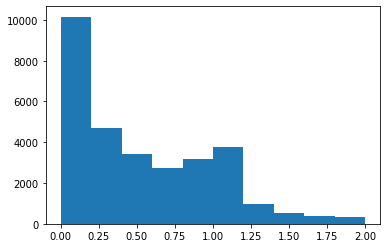

In [ ]:
from matplotlib import pyplot as plt 

plt.hist(pred_less)

(array([5400., 3391., 2777., 2610., 3924., 7353., 1891., 1137.,  751.,
         874.]),
 array([1.09849407e-03, 2.00988498e-01, 4.00878503e-01, 6.00768507e-01,
        8.00658512e-01, 1.00054852e+00, 1.20043852e+00, 1.40032852e+00,
        1.60021853e+00, 1.80010853e+00, 1.99999854e+00]),
 <a list of 10 Patch objects>)

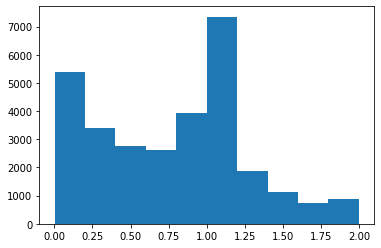

In [ ]:
from matplotlib import pyplot as plt 

plt.hist(pred_more)

(array([ 120.,  300., 1621., 2850., 5645., 7222., 5697., 4932., 1152.,
         569.]),
 array([-1.98380065, -1.58704052, -1.19028039, -0.79352026, -0.39676013,
         0.        ,  0.39676013,  0.79352026,  1.19028039,  1.58704052,
         1.98380065]),
 <a list of 10 Patch objects>)

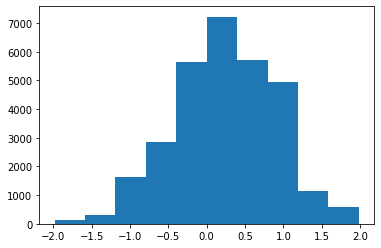

In [ ]:
plt.hist(pred_more - pred_less) #ideally should not have anything below 0 or at 03